<img src="media/logo.jpg" width="300">

# Master 2 VMI - TP RF : Convolutionnal Neural Network (CNN) 

Prérequis pour ce TP : disposer d'un compte Google
* Télécharger ce projet GitHub sur votre machine locale
* Uploader ensuite ce projet dans un dossier lié à votre compte Google Drive
* Ouvrir Google Collab et rechercher votre projet
* Vous pouvez alors exécuter les différentes étapes sucessivement de ce notebook en local sur le serveur Google Collab, ce qui vous évite de disposer d'un GPU en local

## La classification
La classification est un precessus qui prend une entrée une donnée (par exemple, une image et ses pixels) et qui repond par une decision en sortie (chien, chat, ...) ou la probabiltée de chacune des classes considérées.

## Les réseaux de neurones convolutionnels (CNN)
Les CNN sont des réseaux profonds composés de différentes couches dans le but d'extraire (d'apprendre) des caractéristiques permettant de différencier les classes traitées. 

<img src="media/architecture-cnn-fr.png" width="800">

## Types de couche

### Couche de convolution
Le principe de la convolution est de glisser un masque sur l'ensemble des pixels de l'image et de calculer le produit de convolution pour chacun des pixels couverts par ce masque.
<img src="media/convolution-layer-a.png" width="500">
*Remarque : l'étape de convolution peut aussi être généralisée dans les cas 1D et 3D.*

### Couche de pooling
Cette couche a pour but de réduire la dimension spatiale afin de ne garder que les information pertinentes. En particulier, les types de pooling les plus populaires sont le max et l'average pooling.

|   Max Pooling        |   Avreage Pooling   |
:-------------------:  |  :-------------------------:
|<img src="media/max-pooling-a.png" width="300"> | <img src="media/average-pooling-a.png" width="300">  |

# CNN pour la classification d'images 

Dans ce TP, le but est d'utiliser l'approntissage profond pour faire une classification d'images. Pour cela, la necessité d'une base de donnée est indispenssable. Nous allons utiliser ici la base CIFARE10.

## CIFARE10

CIFAR10 est constituée de 10 classes avec 6000 images dans chaque classe, amenant à 60 000 images au total. Cet ensemble d'images est divisé en 2 sous-ensembles : un ensemble pour l'entraînement qui contient 50 000 images et un ensemble pour le test qui contient 10 000 images.

Les classes de cette base de données sont : 

* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Les images de cette base sont de talle 3x32x32 (des imagettes en couleur RGB).

<img src="media/cifar10.png">

## Chargement de la base


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [#transforms.Resize((224, 224), interpolation=2),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)


##########################################################################
#    Chargement/telechargement de la base de TRAIN de CIFARE10           #
##########################################################################

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

##########################################################################
#    Chargement/telechargement de la base de TEST de CIFARE10            #
##########################################################################

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

##########################################################################
#   Definition du module pour parcourir les donnees                      #
# Paramètres:                                                            #
#       - Batchsize (nb d'images qui passent en une fois avant retropropagation)#
#       - shuffle (ordre de passage aléatoire des images) :              #
#                   Vrai      ---> lors de l'entraînement                #
#                   Faux/Vrai ---> lors du test                          #
#                                                                        #
# * On va creer 2 modules : un pour le TRAIN et un pour le TEST          #
##########################################################################

trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


### Visualisation de quelques images de l'ensemble d'entraînement

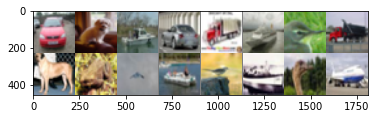

  car   dog  ship   car


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    ##########################################################################################
    #   Il faut transposée les images car PyTorch lis les image en [Chanels, Width, Height]  #
    #   et pour les voir il faut qu'elles soient [Width, Height, Chanels]                    #
    ##########################################################################################
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Création d'un CNN simple avec 2 couches de convolutions

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, in_channels=3, nb_class=4):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=5, stride=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Conv2d(in_channels=128, out_channels=nb_class, kernel_size=1),
            nn.AdaptiveAvgPool2d((1,1))
            #nn.Linear(in_features=128 * 5 * 5, out_features=1024),
            #nn.Dropout(p=0.5),
            #nn.Linear(in_features=2048, out_features=2048),
            #nn.Dropout(p=0.5),
            #nn.Linear(in_features=1024, out_features=nb_class)
        )
    
    def forward(self, x):
        x = self.features(x)
        #x = x.view(x.size(0), -1) #flattening
        x = self.classifier(x)
        #print(x.size())
        return x.view(x.size(0), -1)

 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Net(in_channels=3, nb_class=10).to(device)
print(net)

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Conv2d(12

### Definition de la fonction Loss et de l'optimizeur

Exemple ici : Classification Cross-Entropy loss et SGD avec momentum.

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Entraînement du reseau


In [6]:
###############################################
#   * Fixer les paramètres de l'entraînement   #
###############################################
  
nb_epoch = 10 # Le nombre d'epoch
loss_list = [] # liste qui va contenir la valeur du loss a chaque epoch
for epoch in range(nb_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    nb_data = 0.
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))              # Forward
        loss = criterion(outputs, labels.to(device))
        loss.backward()                    # Backward
        optimizer.step()                   # optimize
 
        # print statistics
        running_loss += loss.item()
        
        nb_data += 1.
        
    running_loss = running_loss / nb_data
    loss_list.append(running_loss)    
    print("Epoch ", epoch, "; train loss = ", running_loss) 
    
torch.save({
                'nb_epoch': nb_epoch,
                'model' : net.state_dict(),
                'listLoss': loss_list,
            }, "modelNN.pth")

print('Finished Training and save the model as `modelNN.pth`')

KeyboardInterrupt: 

### Tracer la courbe du loss

In [ ]:
plt.plot(range(len(loss_list)), loss_list)

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

### Tester le modèle sur les données de test

In [ ]:
# Charger un batch de l'ensemble de test
dataiter = iter(testloader)
images, labels = dataiter.next()

# Passer le batch dans le reseau
outputs = net(images.to(device))
predicted1 = torch.softmax(outputs.data, 1) #decision probabiliste (floue)

_, predicted2 = torch.max(predicted1, 1) #decision dure (classification)


# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('Predicted: ', ' '.join('%5s' % classes[predicted2[j]] for j in range(4)))

## Evaluation du modèle

### Taux de reconnaissance global

In [ ]:
correct = 0.
total = 0.
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.detach().cpu().data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % ( 100. * correct / total))

### Taux de reconnaissance de chacune des classes

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.detach().cpu().data, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %f %%' % (classes[i], 100. * class_correct[i] / class_total[i]))

## Exercices - A vous de jouer ...
* 1) Essayer de faire varier le nombre d'epochs pour améliorer la capacité du réseau à discriminer les différentes catégories d'images. Quel est le nombre d'epochs optimal ?

* 2) Pour ne pas tomber dans un phénomène de sur-apprentissage, modifier le code donné ci-dessus pour intégrer un ensemble de validation qui permet de déterminer les hyper-paramètres du réseau et notamment un nombre d'epochs adapté. 

* 3) Essayer de modifier l'architecture du réseau pour améliorer le taux de reconnaissance de ce dernier. Vous devez faire attention au nombre de filtres utilisés et à la dimension des données de sortie.

* 4) Proposer une interface permettant de visualiser les sorties des filtres de la première couche.

* 5) Refaire cet exercice en utilisant un autre réseau comme SqueezeNet déjà pré-entrainé sur ImageNet que vous affiner (fine-tuning) sur les classes de CIFAR10.